## We are Creating a Stock AMmrket Close_Price Predictor 


In [20]:
import os
import pandas as pd

# Klasör yolu
folder_path = "/Users/omerfarukteker/Desktop/my_test/Stock_Prediction/"

# CSV dosyalarını bul
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Boş bir liste oluştur
dataframes = []

# Her CSV dosyasını oku ve listeye ekle
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    
    # Hangi dosyadan geldiğini belirtmek için opsiyonel olarak bir sütun ekleyebilirsin
    df['filename'] = file
    
    dataframes.append(df)

# Tüm DataFrame'leri birleştir
df_full = pd.concat(dataframes, ignore_index=True)

# İlk birkaç satırı göster
print(df_full.head())


  symbol        date      open      high       low     close    volume  \
0    AAL  2014-01-02   25.0700   25.8200   25.0600   25.3600   8998943   
1   AAPL  2014-01-02   79.3828   79.5756   78.8601   79.0185  58791957   
2    AAP  2014-01-02  110.3600  111.8800  109.2900  109.7400    542711   
3   ABBV  2014-01-02   52.1200   52.3300   51.5200   51.9800   4569061   
4    ABC  2014-01-02   70.1100   70.2300   69.4800   69.8900   1148391   

                            filename  
0  SP 500 Stock Prices 2014-2017.csv  
1  SP 500 Stock Prices 2014-2017.csv  
2  SP 500 Stock Prices 2014-2017.csv  
3  SP 500 Stock Prices 2014-2017.csv  
4  SP 500 Stock Prices 2014-2017.csv  



1.Tarihi 'Datetime' Türüne Çevirme 


2.Gereksiz Verileri Ölçekleme(örneğin sembol veya tarih dışındaki tüm sayısal sütunları)

3.Ölçeklenmiş veriyi sana görsel olarak göstermek

## With Sample's ##

In [32]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 0) Tüm df_full'den rastgele 10.000 satır al
df_sample = df_full.sample(n=10000, random_state=42).copy()

# 1) Tarih formatını dönüştür ve sırala
df_sample['date'] = pd.to_datetime(df_sample['date'])
df_sample = df_sample.sort_values(by=['symbol', 'date']).reset_index(drop=True)

# Eğer filename varsa atalım
if 'filename' in df_sample.columns:
    df_sample = df_sample.drop(columns=['filename'])

# Ölçeklenecek sütunlar
features_to_scale = ['open', 'high', 'low', 'close', 'volume']

# Benzersiz sembolleri alfabetik sırada al
symbols_clean = sorted(df_sample['symbol'].unique())

# Tüm semboller için doğru şekilde ölçekleme yapalım
scaled_frames = []
scaler = MinMaxScaler()

for symbol in symbols_clean:
    temp = df_sample[df_sample['symbol'] == symbol].copy()
    temp[features_to_scale] = scaler.fit_transform(temp[features_to_scale])
    scaled_frames.append(temp)

# Birleştir ve tekrar sırala
df_scaled = (
    pd.concat(scaled_frames)
      .sort_values(by=['symbol', 'date'])
      .reset_index(drop=True)
)

# 'close_tomorrow' hedef sütununu ekle
df_scaled['close_tomorrow'] = (
    df_scaled.groupby('symbol')['close'].shift(-1)
)

# Sonuç: Rastgele 100 satır göster
print(df_scaled.sample(n=100, random_state=42))


     symbol       date      open      high       low     close    volume  \
6252    MSI 2014-02-21  0.239877  0.246121  0.234518  0.231006  0.036021   
4684    IFF 2017-07-12  0.671710  0.665098  0.676308  0.680795  0.213816   
1731    CBS 2014-09-08  0.764553  0.749782  0.768977  0.779930  0.273458   
4742   INFO 2016-02-24  0.196827  0.192153  0.209491  0.216216  0.087893   
4521    HRL 2017-05-05  0.555773  0.539991  0.551882  0.535877  0.053035   
...     ...        ...       ...       ...       ...       ...       ...   
3787   FOXA 2017-02-03  0.661959  0.641457  0.659804  0.640805  0.035409   
9189    UTX 2014-01-09  0.752588  0.738890  0.737490  0.734975  0.000000   
7825    RMD 2016-11-03  0.223003  0.221874  0.226235  0.214536  0.127550   
7539     PX 2014-09-24  0.775538  0.776240  0.776975  0.789091  0.378813   
7231    PHM 2016-01-15  0.000000  0.000000  0.000000  0.000000  0.917536   

      close_tomorrow  
6252        0.258074  
4684        0.860535  
1731        0.5677

## Demo İçin AAPL kıllanımı 



In [36]:
import pandas as pd

# 1) Öncül: Ölçeklenmiş CSV'yi yükleyelim
df = df_scaled.copy()
df = df.sort_values(["symbol","date"]).reset_index(drop=True)

# 2) Demo için tek bir sembol seçelim
symbol = "AAPL"
df_sym = df[df["symbol"] == symbol].copy()

# 3) Lag özellikleri
df_sym["close_lag_1"] = df_sym["close"].shift(1)
df_sym["close_lag_2"] = df_sym["close"].shift(2)

# 4) Rolling özellikleri
df_sym["rolling_mean_3"] = df_sym["close"].rolling(window=3).mean()
df_sym["rolling_std_3"]  = df_sym["close"].rolling(window=3).std()

# 5) Zaman özellikleri
df_sym["day_of_week"] = df_sym["date"].dt.dayofweek
df_sym["month"]       = df_sym["date"].dt.month

# 6) Hedef: Bir sonraki gün kapanışı
df_sym["close_tomorrow"] = df_sym["close"].shift(-1)

# 7) NaN içeren ilk birkaç satırı atalım
df_sym = df_sym.dropna().reset_index(drop=True)

# Sonucu inceleyelim
print(df_sym.head(10))


  symbol       date      open      high       low     close    volume  \
0   AAPL 2014-04-25  0.056448  0.066421  0.063910  0.069159  1.000000   
1   AAPL 2014-05-19  0.112693  0.125088  0.120166  0.123570  0.780323   
2   AAPL 2014-06-03  0.164362  0.177233  0.172292  0.178482  0.705108   
3   AAPL 2014-06-11  0.215764  0.218039  0.216192  0.210946  0.371281   
4   AAPL 2014-07-10  0.211392  0.227220  0.216782  0.224653  0.298634   
5   AAPL 2014-07-24  0.250090  0.247788  0.251004  0.247926  0.371860   
6   AAPL 2014-08-27  0.297177  0.308797  0.301511  0.307420  0.452318   
7   AAPL 2014-10-02  0.276499  0.281488  0.270121  0.281406  0.396445   
8   AAPL 2014-10-16  0.232543  0.252437  0.239085  0.238943  0.692057   
9   AAPL 2014-11-14  0.440506  0.443830  0.447251  0.447989  0.351682   

   close_tomorrow  close_lag_1  close_lag_2  rolling_mean_3  rolling_std_3  \
0        0.123570     0.009415     0.000000        0.026191       0.037508   
1        0.178482     0.069159     0.009

# 4)Fearture Engineering

In [37]:
# 4) Feature engineering fonksiyonu
def featurize(df_sym):
    df_sym = df_sym.sort_values("date").reset_index(drop=True)
    df_sym["close_lag_1"] = df_sym["close"].shift(1)
    df_sym["close_lag_2"] = df_sym["close"].shift(2)
    df_sym["rolling_mean_3"] = df_sym["close"].rolling(3).mean()
    df_sym["rolling_std_3"] = df_sym["close"].rolling(3).std()
    df_sym["day_of_week"] = df_sym["date"].dt.dayofweek
    df_sym["month"] = df_sym["date"].dt.month
    df_sym["close_tomorrow"] = df_sym["close"].shift(-1)
    return df_sym.dropna()

In [38]:
# 5) Tüm sembollere uygula
chunks = []
for symbol in sorted(df_scaled["symbol"].unique()):
    df_sym = df_scaled[df_scaled["symbol"] == symbol].copy()
    df_feat = featurize(df_sym)
    chunks.append(df_feat)

df_final = pd.concat(chunks).reset_index(drop=True)

In [39]:
# 6) Sonuç: random 10 satır ve boyut bilgisi
print("Tüm Semboller için Özellik Eklenmiş Veri (10k sample) — Rastgele 10 Satır:")
print(df_final.sample(10))

print(f"Örnek veri boyutu: {df_final.shape}")


Tüm Semboller için Özellik Eklenmiş Veri (10k sample) — Rastgele 10 Satır:
     symbol       date      open      high       low     close    volume  \
2712    EOG 2014-07-30  1.000000  1.000000  1.000000  1.000000  0.000000   
1311    BWA 2016-07-14  0.000000  0.000000  0.000000  0.000000  0.370997   
3692    HII 2014-11-26  0.048235  0.043487  0.045265  0.043811  0.000000   
5476    NEE 2016-08-17  0.538052  0.551862  0.528330  0.551007  0.296841   
4245    JEC 2017-08-10  0.576994  0.578665  0.547311  0.532202  0.493867   
1046    BAC 2015-03-17  0.209076  0.196895  0.204731  0.207091  0.138349   
1736    CLX 2016-08-29  0.845377  0.860598  0.877656  0.888934  0.035907   
3234    FRT 2017-04-05  0.303355  0.295482  0.313546  0.308072  0.281703   
7332    TDG 2015-07-15  0.562419  0.554076  0.539558  0.524497  0.360058   
6056    PFE 2017-08-14  0.834416  0.818255  0.831595  0.823151  0.128468   

      close_tomorrow  close_lag_1  close_lag_2  rolling_mean_3  rolling_std_3  \
2712   

## Differnetiating Test and Train

In [40]:
from sklearn.model_selection import train_test_split
# Random 80/20 split
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42)

# Display result sizes
split_summary = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'Rows': [len(train_df), len(test_df)]
})
print("Random Train/Test Split:")
print(split_summary)


Random Train/Test Split:
     Set  Rows
0  Train  6796
1   Test  1699


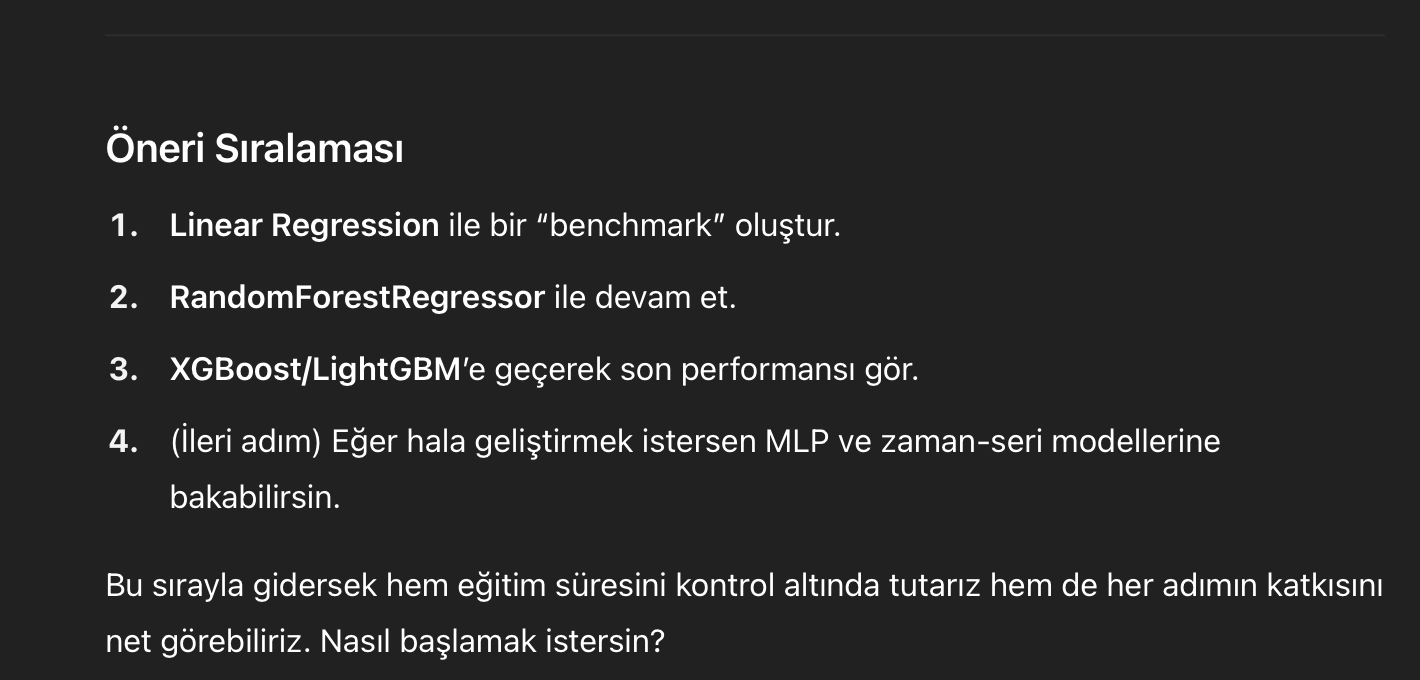

1. Linear Regression ile benchmark

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define feature columns (excluding target and non-feature columns)
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'close_lag_1', 'close_lag_2', 
				'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'month']

X_train = train_df[feature_cols]
y_train = train_df["close_tomorrow"]
X_test  = test_df[feature_cols]
y_test  = test_df["close_tomorrow"]

# 4) Modeli eğit
lr = LinearRegression()
lr.fit(X_train, y_train)

# 5) Tahmin ve metrikler
y_pred = lr.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression MAE:  {mae:.6f}")
print(f"Linear Regression RMSE: {rmse:.6f}")

Linear Regression MAE:  0.126236
Linear Regression RMSE: 0.171866


In [45]:
# Adım 1: Çıktıya ek özellikleri tanımla
def add_advanced_features(df):
    df = df.sort_values("date").reset_index(drop=True)

    # 1) Fiyat farkları
    df["price_diff_1"] = df["close"] - df["close_lag_1"]
    df["price_diff_2"] = df["close"] - df["close_lag_2"]

    # 2) Daha uzun rolling pencereleri
    df["rolling_mean_5"] = df["close"].rolling(5).mean()
    df["rolling_std_5"]  = df["close"].rolling(5).std()
    df["momentum_5"]     = df["close"] - df["rolling_mean_5"]

    # 3) Bollinger bantları (20-günlük)
    df["rolling_mean_20"] = df["close"].rolling(20).mean()
    df["rolling_std_20"]  = df["close"].rolling(20).std()
    df["bollinger_upper"] = df["rolling_mean_20"] + 2 * df["rolling_std_20"]
    df["bollinger_lower"] = df["rolling_mean_20"] - 2 * df["rolling_std_20"]

    # 4) Hacim tabanlı özellikler
    df["volume_lag_1"]      = df["volume"].shift(1)
    df["volume_change"]     = df["volume"] / df["volume_lag_1"]
    df["volume_roll_mean_5"]= df["volume"].rolling(5).mean()

    # 5) Zamanın cyclic encoding’i
    df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # 6) Polinomik etkileşim terimi
    df["lag1_x_rm5"] = df["close_lag_1"] * df["rolling_mean_5"]

    # Son: NaN’leri temizle
    return df.dropna().reset_index(drop=True)

# Adım 2: Sembol bazında uygula
frames = []
for sym, grp in df_final.groupby("symbol"):
    frames.append(add_advanced_features(grp))

df_enhanced = pd.concat(frames).reset_index(drop=True)

# Adım 3: Genişletilmiş tabloyu incele
print("Yeni sütunlarla boyut:", df_enhanced.shape)
print(df_final.sample(10))

Yeni sütunlarla boyut: (478, 29)
     symbol       date      open      high       low     close    volume  \
1435     CB 2017-02-22  0.783839  0.820449  0.791200  0.836859  0.193643   
2991   FBHS 2015-03-31  0.348246  0.357220  0.347274  0.358279  0.418078   
5056    MHK 2016-03-11  0.367366  0.379969  0.363216  0.379675  0.205735   
6948    SNA 2016-05-12  0.910091  0.901642  0.882618  0.902331  0.534278   
2319    DIS 2016-07-12  0.632289  0.633273  0.637718  0.623167  0.580713   
2029    CRM 2017-09-28  0.948353  0.934752  0.944429  0.922903  0.153924   
3379   GOOG 2015-01-08  0.000000  0.000000  0.000000  0.000000  0.882199   
5920   PBCT 2015-02-26  0.150538  0.161496  0.190432  0.170412  0.139319   
3824    HRL 2016-07-14  0.627691  0.621865  0.637261  0.629950  0.603971   
4703    LNT 2017-05-23  0.809704  0.863031  0.843227  0.850240  0.840046   

      close_tomorrow  close_lag_1  close_lag_2  rolling_mean_3  rolling_std_3  \
1435        0.845445     0.706178     0.622199   

In [50]:
# 1) Train/test split for enhanced dataset
train_df_enh, test_df_enh = train_test_split(df_enhanced, test_size=0.2, random_state=42)

# 2) Define enhanced feature columns
feature_cols_enhanced = ['open', 'high', 'low', 'close', 'volume', 'close_lag_1', 'close_lag_2', 
						'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'month',
						'price_diff_1', 'price_diff_2', 'rolling_mean_5', 'rolling_std_5', 
						'momentum_5', 'bollinger_upper', 'bollinger_lower', 'volume_lag_1', 
						'volume_change', 'volume_roll_mean_5', 'dow_sin', 'dow_cos', 'lag1_x_rm5']

# 3) Prepare data and handle infinity values
X_train_enh = train_df_enh[feature_cols_enhanced].replace([np.inf, -np.inf], np.nan).fillna(0)
y_train_enh = train_df_enh["close_tomorrow"]
X_test_enh = test_df_enh[feature_cols_enhanced].replace([np.inf, -np.inf], np.nan).fillna(0)
y_test_enh = test_df_enh["close_tomorrow"]

# 4) Train the model
lr_enhanced = LinearRegression()
lr_enhanced.fit(X_train_enh, y_train_enh)

# 5) Make predictions and calculate metrics
y_pred_enh = lr_enhanced.predict(X_test_enh)
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)
rmse_enh = np.sqrt(mean_squared_error(y_test_enh, y_pred_enh))

print(f"Enhanced Linear Regression MAE:  {mae_enh:.6f}")
print(f"Enhanced Linear Regression RMSE: {rmse_enh:.6f}")

Enhanced Linear Regression MAE:  0.093256
Enhanced Linear Regression RMSE: 0.127349


2. Random Forest Regressor


In [56]:
from sklearn.ensemble import RandomForestRegressor

# Use existing df_enhanced instead of creating new one
# df_enhanced is already created in previous cells with advanced features

# Clean any infinity values in df_enhanced
df_enhanced_clean = df_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# 5) Train/Test Split
feature_cols = [
    "open","high","low","close","volume",
    "close_lag_1","close_lag_2","rolling_mean_3","rolling_std_3",
    "price_diff_1","price_diff_2","rolling_mean_5","rolling_std_5","momentum_5",
    "rolling_mean_20","rolling_std_20","bollinger_upper","bollinger_lower",
    "volume_lag_1","volume_change","volume_roll_mean_5",
    "dow_sin","dow_cos","lag1_x_rm5",
    "day_of_week","month"
]
X = df_enhanced[feature_cols]
y = df_enhanced["close_tomorrow"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6) Random Forest Modeli
# 5) Train/Test Split
feature_cols = [
    "open","high","low","close","volume",
    "close_lag_1","close_lag_2","rolling_mean_3","rolling_std_3",
    "price_diff_1","price_diff_2","rolling_mean_5","rolling_std_5","momentum_5",
    "rolling_mean_20","rolling_std_20","bollinger_upper","bollinger_lower",
    "volume_lag_1","volume_change","volume_roll_mean_5",
    "dow_sin","dow_cos","lag1_x_rm5",
    "day_of_week","month"
]
X = df_enhanced_clean[feature_cols]
y = df_enhanced_clean["close_tomorrow"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# 6) Random Forest Modeli
rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf.fit(X_train, y_train)

# 7) Değerlendirme
y_pred = rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest MAE:  {mae:.6f}")
print(f"Random Forest RMSE: {rmse:.6f}")

Random Forest MAE:  0.094698
Random Forest RMSE: 0.124996


3. Step GradientBoostingRegressor’

In [79]:
from sklearn.model_selection import GridSearchCV
param_grid = {
  "n_estimators": [100, 300, 500],
  "learning_rate": [0.01, 0.05, 0.1],
  "max_depth": [3, 5, 7]
}
gscv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                    param_grid, scoring="neg_mean_absolute_error", cv=3)
gscv.fit(X_train, y_train)
print(gscv.best_params_)


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [80]:


# 3) Modeli tanımla ve eğit
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)

# 4) Tahmin ve metrikler
y_pred = gbr.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Gradient Boosting MAE:  {mae:.6f}")
print(f"Gradient Boosting RMSE: {rmse:.6f}")


Gradient Boosting MAE:  0.095429
Gradient Boosting RMSE: 0.122203
